In [5]:
!python --version

Python 3.10.12


In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## labels

In [20]:
labels = os.listdir("/content/drive/MyDrive/driver_status/train")

In [21]:
labels

['yawn', 'Open', 'no_yawn', 'Closed']


## visualize random 1 image

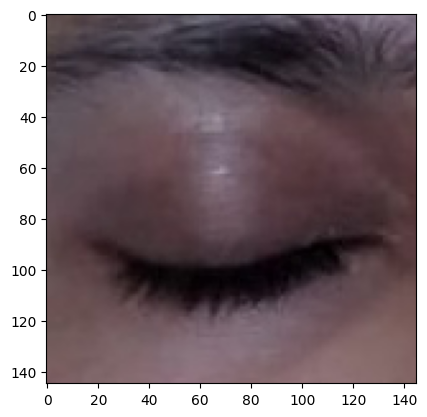

In [22]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/drive/MyDrive/driver_status/train/Closed/_0.jpg"))


## image array

In [23]:
a = plt.imread("/content/drive/MyDrive/driver_status/train/yawn/10.jpg")


## image shape

In [24]:
a.shape

(480, 640, 3)

## visualize yawn image.
Here background is unnecessary. we need only face image array

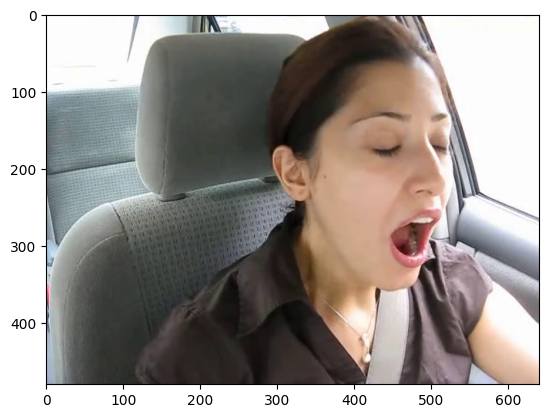

In [25]:
plt.imshow(plt.imread("/content/drive/MyDrive/driver_status/train/yawn/1.jpg"))

## for yawn and not_yawn. Take only face

In [30]:
def face_for_yawn(direc="/content/drive/MyDrive/driver_status/train", face_cas_path="/content/drive/MyDrive/driver_status/input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
            # face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## for closed and open eye

In [31]:
def get_data(dir_path="/content/drive/MyDrive/driver_status/train", face_cas="/content/drive/MyDrive/driver_status/input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="/content/drive/MyDrive/driver_status/input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [32]:
data_train = get_data()

2
3


## extend data and convert array

In [33]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)


## new variable to store

In [34]:
new_data = append_data()

0
1
2
3


<ipython-input-33-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)



## separate label and features

In [35]:
X = []  #데이터
y = []  #라벨
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## reshape the array

In [36]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [37]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)


## label array

In [38]:
y = np.array(y)

## train test split

In [39]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## length of X_test

In [40]:
len(X_test)

578

## Not necessary, only use to matching with my pc version

In [ ]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

## import some dependencies

In [41]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


## tensorflow version

In [42]:
tf.__version__

'2.12.0'


## keras version

In [43]:
import keras
keras.__version__

'2.12.0'

## Data Augmentation

In [44]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [45]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [46]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 22s 225ms/step - loss: 1.1401 - accuracy: 0.5085 - val_loss: 0.6216 - val_accuracy: 0.7128
Epoch 2/50
43/43 [==============================] - 7s 170ms/step - loss: 0.5495 - accuracy: 0.7691 - val_loss: 0.5886 - val_accuracy: 0.7301
Epoch 3/50
43/43 [==============================] - 8s 185ms/step - loss: 0.3916 - accuracy: 0.8300 - val_loss: 0.4265 - val_accuracy: 0.8391
Epoch 4/50
43/43 [==============================] - 9s 203ms/step - loss: 0.3925 - accuracy: 0.8396 - val_loss: 0.2736 - val_accuracy: 0.8927
Epoch 5/50
43/43 [==============================] - 7s 172ms/step - loss: 0.3361 - accuracy: 0.8478 - val_loss: 0.2036 - val_accuracy: 0.9291
Epoch 6/50
43/43 [==============================] - 8s 179ms/step - loss: 0.2889 - accuracy: 0.8716 - val_loss: 0.2209 - val_accuracy: 0.8945
Epoch 7/50
43/43 [==============================] - 9s 205ms/step - loss: 0.2745 - accuracy: 0.8849 - val_loss: 0.2051 - val_accuracy: 0.9187
Epoch

## history

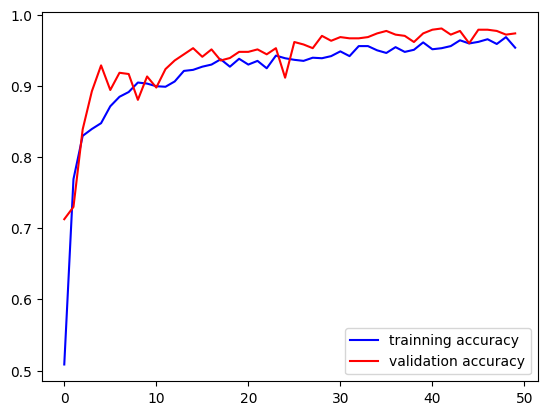

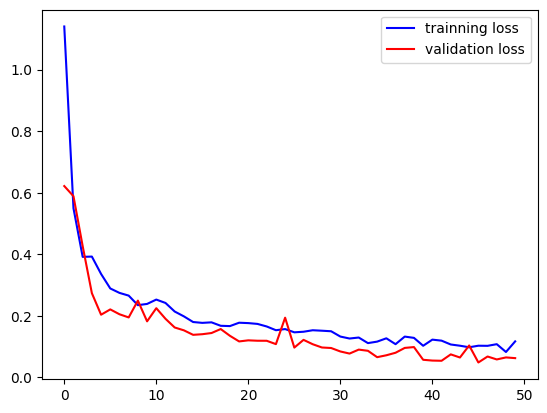

In [47]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## save model

In [48]:
model.save("drowiness_new6.h5")

In [49]:
model.save("drowiness_new6.model")

## Prediction

In [53]:
# prediction = model.predict_classes(X_test)
y_prob = model.predict(X_test)
prediction = y_prob.argmax(axis=-1)

19/19 [==============================] - 1s 27ms/step


In [54]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 2, 3, 2, 2, 2, 3, 1, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 2, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 1, 2, 1, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 3, 2,
       1, 0, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 1, 1, 3, 1, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 1, 1, 3, 2, 2, 3, 3, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 3, 3, 1, 1,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 2, 0, 0,
       0, 1, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 1, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

## classification report

In [55]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [56]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.93      0.83      0.87        63
     no_yawn       0.86      0.92      0.89        74
      Closed       0.96      0.98      0.97       215
        Open       0.97      0.96      0.97       226

    accuracy                           0.95       578
   macro avg       0.93      0.92      0.93       578
weighted avg       0.95      0.95      0.95       578



## predicting function

In [57]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/drive/MyDrive/driver_status/input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

## Prediction
0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [61]:
a = prepare("/content/drive/MyDrive/driver_status/train/no_yawn/1068.jpg")
prediction = model.predict(a)
np.argmax(prediction)

1/1 [==============================] - 0s 277ms/step


1

In [66]:
a = prepare("/content/drive/MyDrive/driver_status/train/Closed/_101.jpg")
prediction = model.predict(a)
np.argmax(prediction)

1/1 [==============================] - 0s 82ms/step


2

In [68]:
prediction = model.predict([prepare("/content/drive/MyDrive/driver_status/train/Open/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 44ms/step


3

In [69]:
prediction = model.predict([prepare("/content/drive/MyDrive/driver_status/train/yawn/113.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 18ms/step


3